# Intro
In this assignment, we employ naive bayes for spam and fake claim classification.

# Datasets
SMS Spam Collection: https://www.kaggle.com/uciml/sms-spam-collection-dataset

Sentimental LIAR: https://github.com/UNHSAILLab/SentimentalLIAR

In [1]:
! gdown --id 1552lhcEasD-ynToYAxTimASaChtR0yt7
! git clone https://github.com/UNHSAILLab/SentimentalLIAR

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1552lhcEasD-ynToYAxTimASaChtR0yt7
To: /content/spam.csv
100% 504k/504k [00:00<00:00, 3.53MB/s]
Cloning into 'SentimentalLIAR'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 41 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


# Preprocessing

In [2]:
! pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 5.5 MB/s 


In [3]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [21]:
import nltk
from spellchecker import SpellChecker
import re


class Preprocessing:
    def __init__(self, techniques=["lowercase", "spellcheck"]):
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt', quiet=True)
        nltk.download('words', quiet=True)
        nltk.download('wordnet', quiet=True)
        self.techniques = techniques
        self.techniques_map = {
            "": lambda x : x,
            "lowercase": self.lowercase,
            "spellcheck": self.spellcheck,
            "stopwords": self.remove_stopwords,
            "lemmatization": self.lemmatization,
            "stemming": self.stemming,
            "alphanumeric": self.alphanumeric
        }

    def preprocess_corpus(self, corpus: list, verbose=False):
        for i in tqdm(range(len(corpus))):
            corpus[i] = self.preprocess(corpus[i])
        return corpus

    def preprocess(self, text, verbose=False):
        words = nltk.tokenize.word_tokenize(text)
        for technique in self.techniques:
            words = self.techniques_map[technique](words)
            if verbose:
                print(technique.ljust(15), words)
        return " ".join(words)

    def lowercase(self, words):
        return [w.lower() for w in words]

    def spellcheck(self, words):
        spell = SpellChecker()
        return [spell.correction(w) for w in words]
    
    def remove_stopwords(self, words):
        return [w for w in words if w not in nltk.corpus.stopwords.words('english')]

    def lemmatization(self, words):
        lemmatizer = nltk.stem.WordNetLemmatizer()
        return [lemmatizer.lemmatize(w) for w in words]

    def stemming(self, words):
        stemmer_ss = nltk.stem.SnowballStemmer("english")
        return [stemmer_ss.stem(w) for w in words]

    def alphanumeric(self, words):
        return [re.sub(r'\W+', '', w) for w in words if re.sub(r'\W+', '', w) != '']


for t in Preprocessing().techniques_map.keys():
    Preprocessing(techniques=[t]).preprocess("Hello wrold to everybody running corpora.!", verbose=True)

                ['Hello', 'wrold', 'to', 'everybody', 'running', 'corpora', '.', '!']
lowercase       ['hello', 'wrold', 'to', 'everybody', 'running', 'corpora', '.', '!']
spellcheck      ['Hello', 'world', 'to', 'everybody', 'running', 'corporal', '.', '!']
stopwords       ['Hello', 'wrold', 'everybody', 'running', 'corpora', '.', '!']
lemmatization   ['Hello', 'wrold', 'to', 'everybody', 'running', 'corpus', '.', '!']
stemming        ['hello', 'wrold', 'to', 'everybodi', 'run', 'corpora', '.', '!']
alphanumeric    ['Hello', 'wrold', 'to', 'everybody', 'running', 'corpora']


# Feature Extraction

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import naive_bayes, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import sklearn

class DatasetHandler:
    def __init__(self, vectorizer, preprocessing_techniques):
        self.preprocessing = Preprocessing(preprocessing_techniques)
        if vectorizer == "tfidf":
            self.vectorizer = TfidfVectorizer(lowercase=False)
        elif vectorizer == "count":
            self.vectorizer = CountVectorizer(lowercase=False)
        else:
            raise f"Unknown vectorizer: {vectorizer}"
        self.label_encoder = LabelEncoder()

    def prepare_xy(self):
        self.x_train = self.preprocessing.preprocess_corpus(self.x_train)
        self.x_test = self.preprocessing.preprocess_corpus(self.x_test)
        self.x_train = self.vectorizer.fit_transform(self.x_train)
        self.x_test = self.vectorizer.transform(self.x_test)
        self.y_train = self.label_encoder.fit_transform(self.y_train)
        self.y_test = self.label_encoder.transform(self.y_test)
        print(self.label_encoder.classes_)

    def get_dataset(self):
        return {
            "x_train": self.x_train, 
            "y_train": self.y_train, 
            "x_test": self.x_test, 
            "y_test": self.y_test
        }

class SpamDatasetHandler(DatasetHandler):
    def __init__(self, vectorizer="tfidf", preprocessing_techniques=[]):
        super().__init__(vectorizer, preprocessing_techniques)
        self.df = pd.read_csv("spam.csv", encoding='latin-1')
        self.df.dropna(axis=1, inplace=True)
        x = self.df["v2"].values
        y = self.df["v1"].values
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2)
        self.prepare_xy()

class LiarDatasetHandler(DatasetHandler):
    def __init__(self, vectorizer="tfidf", preprocessing_techniques=[], extra_cols=[]):
        super().__init__(vectorizer, preprocessing_techniques)
        def read_df(path):
            df = pd.read_csv(path)
            df.replace(['barely-true', 'false', 'pants-fire'], 'false', inplace=True)
            df.replace(['half-true', 'mostly-true', 'true'], 'true', inplace=True)
            x, y = df["statement"].values, df["label"].values
            return x, y
        
        def add_extra_cols(x, path):
            df = pd.read_csv(path)
            df["sentiment"] = df["sentiment"].factorize()[0] + 1
            # d = df[["anger", "fear", "joy", "disgust", "sad"]].values
            if len(extra_cols) > 0 and extra_cols != [""]:
                d = df[extra_cols].values
                est = sklearn.preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
                d = est.fit_transform(d)
                x = x.toarray()
                x = np.concatenate((x, d), axis=-1)
                # x = normalize(x, axis=1)
            return x

        self.x_train, self.y_train = read_df("SentimentalLIAR/train_final.csv")
        self.x_test, self.y_test = read_df("SentimentalLIAR/test_final.csv")
        self.prepare_xy()
        self.x_train = add_extra_cols(self.x_train, "SentimentalLIAR/train_final.csv")
        self.x_test = add_extra_cols(self.x_test, "SentimentalLIAR/test_final.csv")

# sdh = SpamDatasetHandler(vectorizer="count", preprocessing_techniques=[])
# dataset = sdh.get_dataset()

# Training/Evaluating Classifiers

In [55]:
class Trainer:
    def __init__(self, dataset_handler):
        self.dataset = dataset_handler.get_dataset()
        self.dataset_handler = dataset_handler

    def train(self):
        # self.clf = naive_bayes.MultinomialNB()
        self.clf = naive_bayes.ComplementNB()
        self.clf.fit(self.dataset["x_train"], self.dataset["y_train"])
    
    def eval(self, output_dict=True):
        predictions = self.clf.predict(self.dataset["x_test"])
        return metrics.classification_report(self.dataset['y_test'], 
                                             predictions, 
                                             output_dict=output_dict,
                                             target_names=self.dataset_handler.label_encoder.classes_)

# Final Reports

## Preprocessings

In [29]:
results = {"change": [], "accuracy": [], "macro_f1": []}
for p in ["", "lowercase", "stopwords", "lemmatization", "stemming", "alphanumeric"]:
    sdh = SpamDatasetHandler(vectorizer="tfidf", preprocessing_techniques=[p])
    trainer = Trainer(sdh)
    trainer.train()
    report = trainer.eval()
    results["macro_f1"].append(report["macro avg"]["f1-score"])
    results["accuracy"].append(report["accuracy"])
    results["change"].append(p)
print("SPAM Dataset")
pd.DataFrame(results)

  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


In [35]:
sdh = SpamDatasetHandler(vectorizer="tfidf", preprocessing_techniques=["lemmatization", "stopwords"])
trainer = Trainer(sdh)
trainer.train()
report = trainer.eval()
results["macro_f1"].append(report["macro avg"]["f1-score"])
results["accuracy"].append(report["accuracy"])
results["change"].append("lemmatization + stopwords")
print("SPAM Dataset")
pd.DataFrame(results)

  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']


In [37]:
results = {"change": [], "accuracy": [], "macro_f1": []}
for p in ["", "lowercase", "stopwords", "lemmatization", "stemming", "alphanumeric"]:
    ldh = LiarDatasetHandler(vectorizer="tfidf", preprocessing_techniques=[p], extra_cols=[])
    trainer = Trainer(ldh)
    trainer.train()
    report = trainer.eval()
    results["macro_f1"].append(report["macro avg"]["f1-score"])
    results["accuracy"].append(report["accuracy"])
    results["change"].append(p)
print("Liar Dataset")
pd.DataFrame(results)

  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']
Liar Dataset


,change,accuracy,macro_f1
0,,0.599053,0.527516
1,lowercase,0.604578,0.535034
2,stopwords,0.599053,0.536018
3,lemmatization,0.602210,0.533251
4,stemming,0.610103,0.548195
5,alphanumeric,0.597474,0.524273


In [39]:
ldh = LiarDatasetHandler(vectorizer="tfidf", preprocessing_techniques=["lowercase", "stopwords", "lemmatization", "stemming"], extra_cols=[])
trainer = Trainer(ldh)
trainer.train()
report = trainer.eval()
results["macro_f1"].append(report["macro avg"]["f1-score"])
results["accuracy"].append(report["accuracy"])
results["change"].append("all - alphanumeric")
print("Liar Dataset")
pd.DataFrame(results)

  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']
Liar Dataset


,change,accuracy,macro_f1
0,,0.599053,0.527516
1,lowercase,0.604578,0.535034
2,stopwords,0.599053,0.536018
3,lemmatization,0.602210,0.533251
4,stemming,0.610103,0.548195
5,alphanumeric,0.597474,0.524273
6,all,0.607735,0.551109
7,all - alphanumeric,0.606946,0.551636


## Features

In [47]:
sdh = SpamDatasetHandler(vectorizer="count", preprocessing_techniques=[])
trainer = Trainer(sdh)
trainer.train()
report = trainer.eval(output_dict=False)
print(report)

  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       974
        spam       0.98      0.90      0.94       141

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [48]:
np.unique(sdh.get_dataset()["y_test"], return_counts=True)

(array([0, 1]), array([974, 141]))

In [59]:
ldh = LiarDatasetHandler(vectorizer="tfidf", preprocessing_techniques=["lowercase", "stopwords", "lemmatization", "stemming", "alphanumeric"], extra_cols=[])
trainer = Trainer(ldh)
trainer.train()
report = trainer.eval()
report = trainer.eval(output_dict=False)
print(report)

  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']
              precision    recall  f1-score   support

       false       0.57      0.51      0.54       553
        true       0.65      0.70      0.67       714

    accuracy                           0.62      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.61      0.62      0.61      1267



In [75]:
results = {"change": [], "accuracy": [], "macro_f1": []}
for col in ["", "sentiment", "anger", "fear", "joy", "disgust", "sad"]:
    ldh = LiarDatasetHandler(vectorizer="count", preprocessing_techniques=[], extra_cols=[col])
    trainer = Trainer(ldh)
    trainer.train()
    report = trainer.eval()
    results["macro_f1"].append(report["macro avg"]["f1-score"])
    results["accuracy"].append(report["accuracy"])
    results["change"].append(col)
pd.DataFrame(results).sort_values("macro_f1", ascending=False)

  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


,change,accuracy,macro_f1
2,anger,0.625099,0.615321
5,disgust,0.616417,0.606514
3,fear,0.617206,0.605747
0,,0.615627,0.604340
1,sentiment,0.615627,0.604340
6,sad,0.615627,0.603678
4,joy,0.614838,0.603418


In [77]:
ldh = LiarDatasetHandler(vectorizer="count", 
                            # preprocessing_techniques=["lowercase", "stopwords", "lemmatization", "stemming", "alphanumeric"], 
                            extra_cols=["anger", "fear", "disgust"])
trainer = Trainer(ldh)
trainer.train()
report = trainer.eval()
results["macro_f1"].append(report["macro avg"]["f1-score"])
results["accuracy"].append(report["accuracy"])
results["change"].append("anger+fear+disgust")
pd.DataFrame(results).sort_values("macro_f1", ascending=False)

  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']


,change,accuracy,macro_f1
2,anger,0.625099,0.615321
7,all,0.620363,0.610259
8,anger+fear+disgust,0.619574,0.610149
5,disgust,0.616417,0.606514
3,fear,0.617206,0.605747
0,,0.615627,0.604340
1,sentiment,0.615627,0.604340
6,sad,0.615627,0.603678
4,joy,0.614838,0.603418


## Best Results

In [81]:
sdh = SpamDatasetHandler(vectorizer="count", preprocessing_techniques=[])
trainer = Trainer(sdh)
trainer.train()
report = trainer.eval(output_dict=False)
print(report)

  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

['ham' 'spam']
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       979
        spam       0.93      0.93      0.93       136

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [84]:
ldh = LiarDatasetHandler(vectorizer="count", 
                         preprocessing_techniques=["lowercase", "stopwords", "lemmatization", "stemming", "alphanumeric"], 
                         extra_cols=["anger"])
trainer = Trainer(ldh)
trainer.train()
report = trainer.eval()
report = trainer.eval(output_dict=False)
print(report)

  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

['false' 'true']
              precision    recall  f1-score   support

       false       0.57      0.55      0.56       553
        true       0.66      0.68      0.67       714

    accuracy                           0.62      1267
   macro avg       0.61      0.61      0.61      1267
weighted avg       0.62      0.62      0.62      1267



# Analyzing Data

In [85]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.dropna(axis=1, inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [34]:
df = pd.read_csv("SentimentalLIAR/train_final.csv")
df.replace(['barely-true', 'false', 'pants-fire'], 'false', inplace=True)
df.replace(['half-true', 'mostly-true', 'true'], 'true', inplace=True)
df["label"] = df["label"].factorize()[0]
df["sentiment"] = df["sentiment"].factorize()[0]
df = df[["label", 'statement', 'barely_true_counts', 'false_counts', 
         'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 
         'sentiment', 'anger', 'fear', 'joy', 'disgust', 'sad']]
df.head()

,label,statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,sentiment,anger,fear,joy,disgust,sad
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,0,0.121137,0.008926,0.026096,0.263479,0.531887
1,1,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,0,0.095352,0.124566,0.191357,0.016999,0.102045
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,0,0.039559,0.024162,0.500384,0.454228,0.052453
3,0,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0,0,0.004804,0.194674,0.375055,0.022509,0.383403
4,1,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0,-1,0.044237,0.215996,0.222402,0.045672,0.274343


In [35]:
df.corr()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,sentiment,anger,fear,joy,disgust,sad
label,1.000000,-0.000633,-0.062262,0.070094,0.084058,-0.164989,0.020215,-0.061034,0.026453,0.016258,-0.050221,0.055714
barely_true_counts,-0.000633,1.000000,0.921732,0.912792,0.881851,0.424520,0.033792,-0.013528,0.028029,0.022184,-0.011787,-0.020500
false_counts,-0.062262,0.921732,1.000000,0.756745,0.709571,0.652984,0.025741,-0.004304,0.022652,0.018319,0.000578,-0.021834
half_true_counts,0.070094,0.912792,0.756745,1.000000,0.987453,0.217216,0.038867,-0.036559,0.020675,0.032504,-0.028565,-0.020721
mostly_true_counts,0.084058,0.881851,0.709571,0.987453,1.000000,0.157118,0.040340,-0.036843,0.018790,0.030359,-0.025304,-0.023504
pants_on_fire_counts,-0.164989,0.424520,0.652984,0.217216,0.157118,1.000000,-0.005595,0.030494,0.004230,0.005185,0.022060,-0.035677
sentiment,0.020215,0.033792,0.025741,0.038867,0.040340,-0.005595,1.000000,-0.036853,-0.021483,0.115659,-0.031433,-0.027645
anger,-0.061034,-0.013528,-0.004304,-0.036559,-0.036843,0.030494,-0.036853,1.000000,0.077963,-0.398889,0.315746,-0.003933
fear,0.026453,0.028029,0.022652,0.020675,0.018790,0.004230,-0.021483,0.077963,1.000000,-0.243839,-0.116274,0.157518
joy,0.016258,0.022184,0.018319,0.032504,0.030359,0.005185,0.115659,-0.398889,-0.243839,1.000000,-0.392855,-0.328181


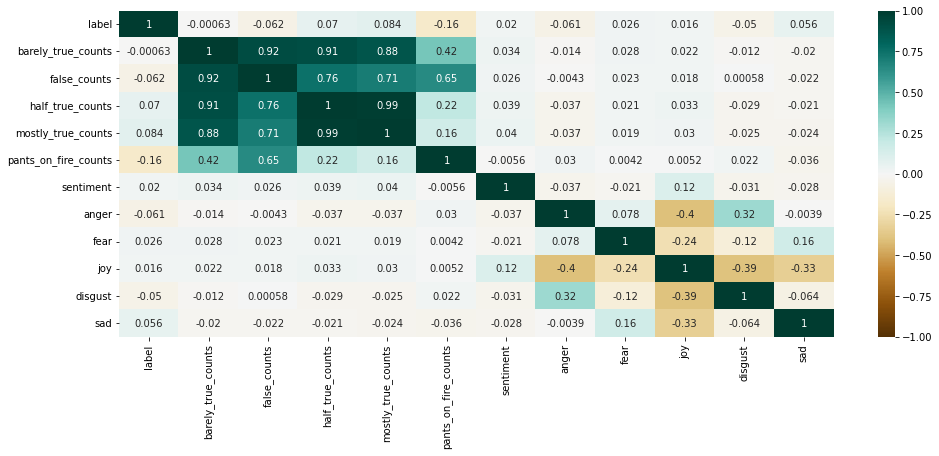

In [42]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')